In [1]:
import geopandas as gpd

In [2]:
import json
import geopandas as gpd
import pandas as pd

# Load the GeoJSON file as a JSON object
with open('df_nearby_businesses.geojson', 'r') as f:
    geojson_data = json.load(f)

# Extract the 'Business Type' field from the features
business_types = [feature['properties'].get('Business Type', []) for feature in geojson_data['features']]

# Load the GeoJSON file into a GeoDataFrame (without the problematic field)
df_nearby_businesses = gpd.read_file('df_nearby_businesses.geojson', ignore_geometry=False)

Skipping field Business Type: unsupported OGR type: 5


In [3]:
chicken_rep_lagos_branch = gpd.read_file('chicken_rep_lagos_branch.geojson')
df_nearby_poi = gpd.read_file('df_nearby_poi.geojson')

In [4]:
df_nearby_poi.columns

Index(['distance', 'branch_location', 'branch_latitude', 'branch_longitude',
       'name', 'amenity', 'shop', 'building', 'landuse', 'office', 'brand',
       'operator', 'opening_hours', 'building:levels', 'tourism', 'healthcare',
       'drive_through', 'parking', 'addr:street', 'addr:city', 'addr:postcode',
       'wheelchair', 'internet_access', 'outdoor_seating', 'amenity_category',
       'geometry'],
      dtype='object')

In [5]:
# Display the first few rows of each GeoDataFrame to verify
print("df_nearby_businesses:")
print(df_nearby_businesses.columns)

df_nearby_businesses:
Index(['Name', 'Latitude', 'Longitude', 'Rating', 'Location', 'geometry'], dtype='object')


In [6]:
df_nearby_businesses.Name.value_counts().head(10)

Name
Domino's Pizza                      12
Chicken Republic                    11
Marhaba International Restaurant     9
De Tastee Fried Chicken              8
KFC                                  8
Mr Biggs                             5
Bukka Hut                            5
Mama Cass Restaurant                 5
Funky B&T                            4
Good Heart Restaurant                4
Name: count, dtype: int64

In [7]:
# Remove rows where 'Name' column is 'Chicken Republic'
df_nearby_businesses = df_nearby_businesses[df_nearby_businesses['Name'] != "Chicken Republic"]

# Verify that 'Chicken Republic' has been removed
print(df_nearby_businesses['Name'].value_counts().head(12))

Name
Domino's Pizza                      12
Marhaba International Restaurant     9
KFC                                  8
De Tastee Fried Chicken              8
Mr Biggs                             5
Bukka Hut                            5
Mama Cass Restaurant                 5
Choppies fastfoods                   4
01SHAWARMA Akerele                   4
Calabar Kitchen                      4
Hot Flavor Barbecue                  4
Funky B&T                            4
Name: count, dtype: int64


In [8]:
import geopandas as gpd

# List of restaurants to analyze
restaurants_of_interest = [
    "KFC", "Domino's Pizza", "Marhaba International Restaurant",
    "De Tastee Fried Chicken", "Mr Biggs", "Bukka Hut"
]

# Filter df_nearby_businesses to include only the restaurants of interest
filtered_restaurants = df_nearby_businesses[df_nearby_businesses['Name'].isin(restaurants_of_interest)]

# Ensure both GeoDataFrames are in the same CRS (e.g., EPSG:4326)
chicken_rep_lagos_branch = chicken_rep_lagos_branch.to_crs(epsg=4326)
filtered_restaurants = filtered_restaurants.to_crs(epsg=4326)

# Function to calculate the nearest distance from a restaurant to any Chicken Republic branch
def calculate_nearest_distance(restaurant_geometry):
    # Compute distances to all Chicken Republic branches
    distances = chicken_rep_lagos_branch.geometry.distance(restaurant_geometry)
    # Return the minimum distance
    return distances.min()

# Add a column to store the nearest distance to Chicken Republic branches
filtered_restaurants['nearest_chicken_rep_distance'] = filtered_restaurants.geometry.apply(calculate_nearest_distance)

# Group by restaurant name and calculate the average distance
average_distances = filtered_restaurants.groupby('Name')['nearest_chicken_rep_distance'].mean()

# Print the results
print("Average Distance to Nearest Chicken Republic Branch:")
print(average_distances)

C:\Users\HP\AppData\Local\Temp\ipykernel_1872\1391871165.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = chicken_rep_lagos_branch.geometry.distance(restaurant_geometry)


Average Distance to Nearest Chicken Republic Branch:
Name
Bukka Hut                           0.004130
De Tastee Fried Chicken             0.002497
Domino's Pizza                      0.007558
KFC                                 0.005040
Marhaba International Restaurant    0.001250
Mr Biggs                            0.007396
Name: nearest_chicken_rep_distance, dtype: float64


In [9]:
print("chicken_rep_lagos_branch:")
print(chicken_rep_lagos_branch.columns)

chicken_rep_lagos_branch:
Index(['Location', 'Address', 'Latitude', 'Longitude', 'LGA',
       'distance_to_road_m', 'node_degree', 'road_density_500m', 'geometry'],
      dtype='object')


In [10]:
chicken_rep_lagos_branch['LGA'].value_counts()

LGA
Eti-Osa         12
Alimosho         6
Ikeja            6
Kosofe           6
Mainland         5
Surulere         4
Shomolu          4
Oshodi/Isolo     4
Ikorodu          3
Amuwo Odofin     1
Apapa            1
Mushin           1
Ibeju-Lekki      1
Name: count, dtype: int64

In [11]:
import folium
import geopandas as gpd
from folium.plugins import HeatMap

# Initialize the map using folium
m = folium.Map(
    location=[chicken_rep_lagos_branch['Latitude'].mean(), chicken_rep_lagos_branch['Longitude'].mean()],
    zoom_start=12,
    tiles="OpenStreetMap"
)

# Ensure both GeoDataFrames are in the same CRS (e.g., EPSG:4326)
chicken_rep_lagos_branch = chicken_rep_lagos_branch.to_crs(epsg=4326)
df_nearby_businesses = df_nearby_businesses.to_crs(epsg=4326)

# Function to count nearby businesses within 1 km
def count_nearby_businesses(branch_geometry):
    buffer = branch_geometry.buffer(0.009)  # Buffer by ~1 km
    return df_nearby_businesses[df_nearby_businesses.geometry.within(buffer)].shape[0]

# Add a new column to store the count of nearby businesses
chicken_rep_lagos_branch['nearby_business_count'] = chicken_rep_lagos_branch.geometry.apply(count_nearby_businesses)

# Define a function to create popup content
def create_popup(row):
    return f"""
    <b>Location:</b> {row['Location']}<br>
    <b>Distance to Road:</b> {round(row['distance_to_road_m'], 1)} meters<br>
    <b>Count of Nearby Restaurants (within 1 km):</b> {round(row['nearby_business_count'], 1)}
    """

# Add branches with uniform marker color
for _, row in chicken_rep_lagos_branch.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        tooltip=f"Location: {row['Location']}<br>Distance to Road: {round(row['distance_to_road_m'], 1)}m",
        popup=folium.Popup(create_popup(row), max_width=300)
    ).add_to(m)

# Create a heatmap layer for nearby restaurants
HeatMap(
    data=df_nearby_businesses[['Latitude', 'Longitude']].values.tolist(),
    radius=15,
    blur=10
).add_to(m)

# Add gradient legend for heatmap
gradient_legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 100px; 
            background: linear-gradient(to top, rgba(255,0,0,1), rgba(255,255,0,1), rgba(0,255,0,1));
            border: 2px solid black; z-index: 9999;">
    <div style="position: absolute; top: -20px; text-align: center; width: 100%; font-weight: bold;">Heatmap Intensity</div>
    <div style="position: absolute; bottom: -20px; text-align: center; width: 100%;">High</div>
    <div style="position: absolute; top: -40px; text-align: center; width: 100%;">Low</div>
</div>
'''
m.get_root().html.add_child(folium.Element(gradient_legend_html))

# Add title to the map
title_html = '''
<div style="position: fixed; top: 10px; left: 50%; transform: translateX(-50%); z-index: 9999; 
            font-size: 20px; font-weight: bold; color: black; background-color: white; padding: 10px;">
    Chicken Republic Branches in Lagos with Heatmap of Nearby Restaurants
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map locally as an HTML file
m.save("Chicken_Republic_Branches_in_Lagos_with_Heatmap_of_Nearby_Restaurants.html")

# Display the map
m

In [12]:
import folium
import geopandas as gpd

# Initialize the map using folium
m = folium.Map(
    location=[chicken_rep_lagos_branch['Latitude'].mean(), chicken_rep_lagos_branch['Longitude'].mean()],
    zoom_start=12,
    tiles="OpenStreetMap"
)

# Define a function to assign colors based on distance to road
def get_color(distance):
    if distance < 30:  # Very close to road
        return 'green'
    elif 30 <= distance < 70:  # Moderately close
        return 'yellow'
    else:  # Far from road
        return 'red'

# Apply the color function to the GeoDataFrame
chicken_rep_lagos_branch['color'] = chicken_rep_lagos_branch['distance_to_road_m'].apply(get_color)

# Add branches with color based on distance_to_road_m
for _, row in chicken_rep_lagos_branch.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        color=row['color'],
        fill=True,
        fill_color=row['color'],
        fill_opacity=0.8,
        tooltip=f"Location: {row['Location']}<br>Distance to Road: {row['distance_to_road_m']}m"
    ).add_to(m)

# Add a custom legend
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 150px; height: 120px; 
            border: 2px solid grey; z-index: 9999; font-size: 12px; background-color: white;
            padding: 10px;">
    <b>Legend</b><br>
    <i class="fa fa-circle" style="color:green"></i> &nbsp; <30m<br>
    <i class="fa fa-circle" style="color:yellow"></i> &nbsp; 30–70m<br>
    <i class="fa fa-circle" style="color:red"></i> &nbsp; >70m
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Add a title to the map
title_html = '''
<div style="position: fixed; top: 10px; left: 50%; transform: translateX(-50%); z-index: 9999; 
            font-size: 20px; font-weight: bold; color: black; background-color: white; padding: 10px;">
    Chicken Republic Branches in Lagos: Proximity to Roads
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Save the map locally as an HTML file
m.save("chicken_republic_proximity_map.html")

# Display the map
m

In [13]:
print("df_nearby_poi:")
print(df_nearby_poi.columns)

df_nearby_poi:
Index(['distance', 'branch_location', 'branch_latitude', 'branch_longitude',
       'name', 'amenity', 'shop', 'building', 'landuse', 'office', 'brand',
       'operator', 'opening_hours', 'building:levels', 'tourism', 'healthcare',
       'drive_through', 'parking', 'addr:street', 'addr:city', 'addr:postcode',
       'wheelchair', 'internet_access', 'outdoor_seating', 'amenity_category',
       'geometry'],
      dtype='object')


In [14]:
# Calculate descriptive statistics for distance_to_road_m
distance_stats = chicken_rep_lagos_branch['distance_to_road_m'].describe()

print("Descriptive Statistics for Distance to Major Roads (in meters):")
print(distance_stats)

Descriptive Statistics for Distance to Major Roads (in meters):
count     54.000000
mean      48.733660
std      132.551617
min        0.028947
25%        7.040354
50%       12.825395
75%       29.593069
max      768.638985
Name: distance_to_road_m, dtype: float64


In [15]:
# Calculate descriptive statistics
raod_density_stats = chicken_rep_lagos_branch['road_density_500m'].describe()

print("Descriptive Statistics for road density:")
raod_density_stats

Descriptive Statistics for road density:


count    5.400000e+01
mean     3.215027e+07
std      1.074587e-08
min      3.215027e+07
25%      3.215027e+07
50%      3.215027e+07
75%      3.215027e+07
max      3.215027e+07
Name: road_density_500m, dtype: float64

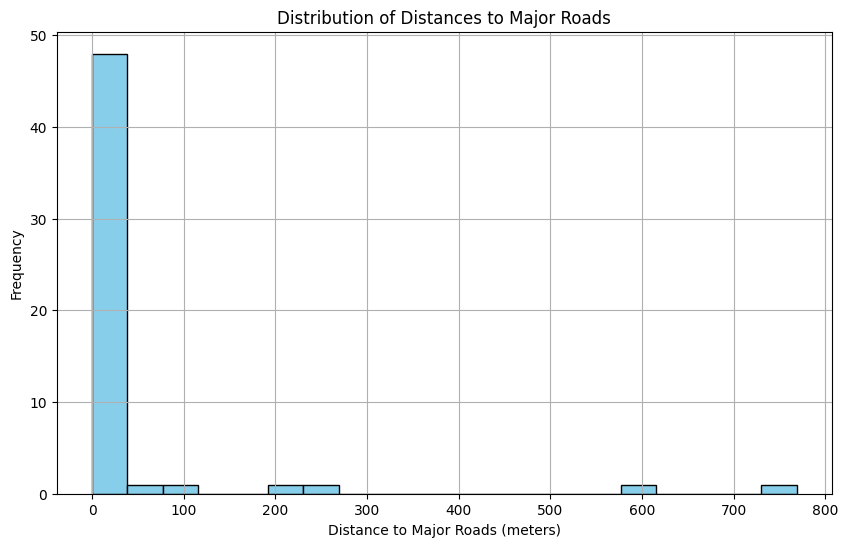

In [16]:
import matplotlib.pyplot as plt

# Histogram of distances
plt.figure(figsize=(10, 6))
plt.hist(chicken_rep_lagos_branch['distance_to_road_m'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Distances to Major Roads')
plt.xlabel('Distance to Major Roads (meters)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

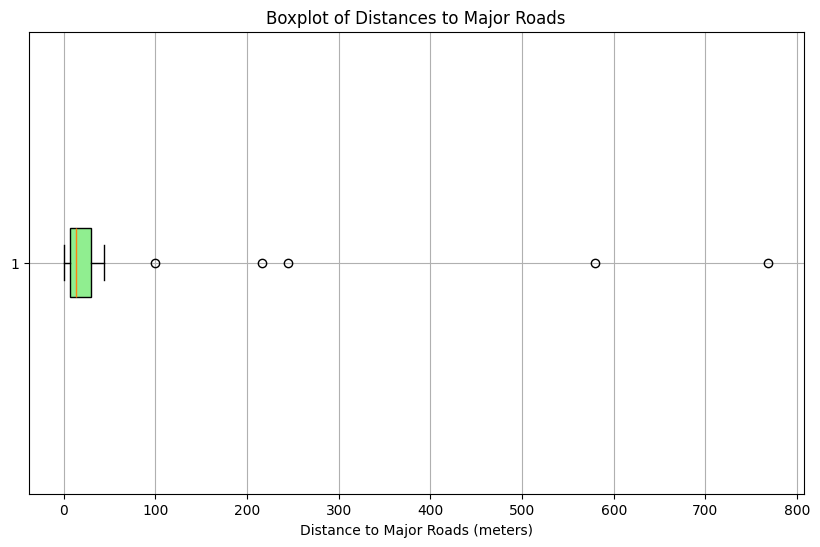

In [17]:

# Boxplot of distances
plt.figure(figsize=(10, 6))
plt.boxplot(chicken_rep_lagos_branch['distance_to_road_m'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightgreen'))
plt.title('Boxplot of Distances to Major Roads')
plt.xlabel('Distance to Major Roads (meters)')
plt.grid(True)
plt.show()

In [18]:
# Categorize branches based on distance
def categorize_distance(distance):
    if distance <= 30:
        return "Very Close (0-30m)"
    elif 30 < distance <= 70:
        return "Ideal Range (30-70m)"
    else:
        return "Far (>70m)"

# Add a new column for distance category
chicken_rep_lagos_branch['distance_category'] = chicken_rep_lagos_branch['distance_to_road_m'].apply(categorize_distance)

# Count the number of branches in each category
distance_category_counts = chicken_rep_lagos_branch['distance_category'].value_counts()

print("Number of Branches in Each Distance Category:")
distance_category_counts

Number of Branches in Each Distance Category:


distance_category
Very Close (0-30m)      41
Ideal Range (30-70m)     8
Far (>70m)               5
Name: count, dtype: int64

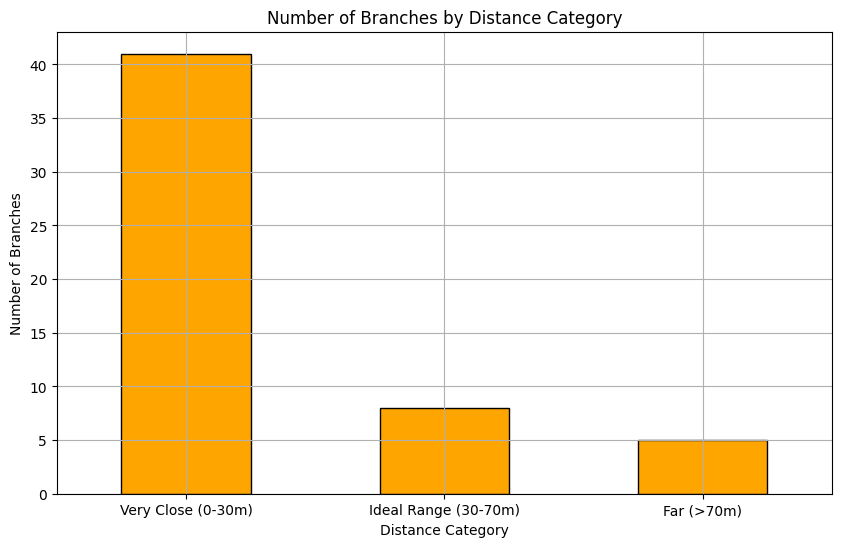

In [19]:
# Bar plot of distance categories
plt.figure(figsize=(10, 6))
distance_category_counts.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Number of Branches by Distance Category')
plt.xlabel('Distance Category')
plt.ylabel('Number of Branches')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

In [20]:
# Descriptive statistics for node_degree and road_density_500m
node_degree_stats = chicken_rep_lagos_branch['node_degree'].describe()
road_density_stats = chicken_rep_lagos_branch['road_density_500m'].describe()

print("Descriptive Statistics for Node Degree:")
node_degree_stats

Descriptive Statistics for Node Degree:


count    54.000000
mean      4.666667
std       1.479419
min       2.000000
25%       4.000000
50%       4.000000
75%       6.000000
max       8.000000
Name: node_degree, dtype: float64

In [21]:
print("\nDescriptive Statistics for Road Density (500m):")
road_density_stats


Descriptive Statistics for Road Density (500m):


count    5.400000e+01
mean     3.215027e+07
std      1.074587e-08
min      3.215027e+07
25%      3.215027e+07
50%      3.215027e+07
75%      3.215027e+07
max      3.215027e+07
Name: road_density_500m, dtype: float64

In [22]:
# Calculate correlation matrix
correlation_matrix = chicken_rep_lagos_branch[['node_degree', 'road_density_500m']].corr()

print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,node_degree,road_density_500m
node_degree,1.000000,-0.093619
road_density_500m,-0.093619,1.000000


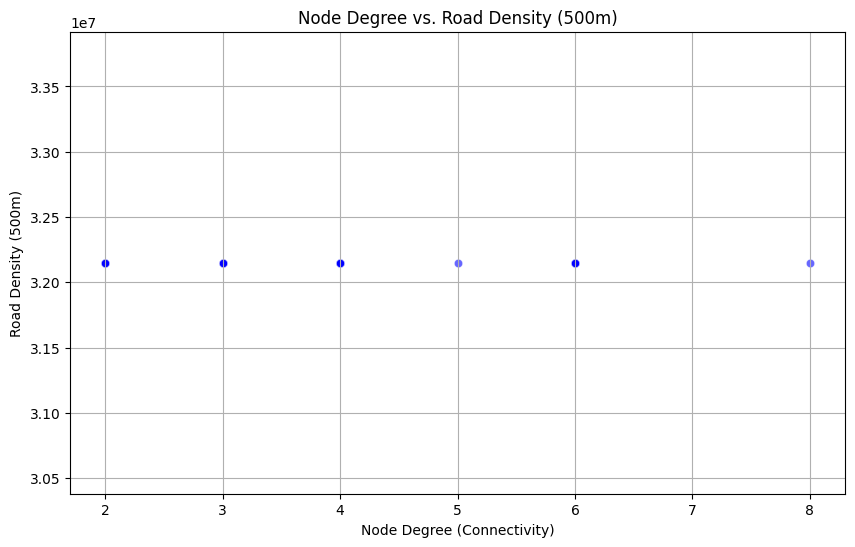

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot: Node Degree vs. Road Density
plt.figure(figsize=(10, 6))
sns.scatterplot(x='node_degree', y='road_density_500m', data=chicken_rep_lagos_branch, color='blue', alpha=0.6)
plt.title('Node Degree vs. Road Density (500m)')
plt.xlabel('Node Degree (Connectivity)')
plt.ylabel('Road Density (500m)')
plt.grid(True)
plt.show()

In [24]:
# Group by amenity and calculate average distance
amenity_avg_distance = df_nearby_poi.groupby('amenity')['distance'].mean().sort_values()

# Group by shop and calculate average distance
shop_avg_distance = df_nearby_poi.groupby('shop')['distance'].mean().sort_values()

print("Average Distance by Amenity Type:")
amenity_avg_distance.head(10)

Average Distance by Amenity Type:


amenity
post_office         1105.678607
police              1198.620340
fuel                1200.213838
community_centre    1203.951178
cafe                1222.106775
hospital            1263.812718
bank                1275.915853
marketplace         1290.186028
clinic              1314.381798
atm                 1359.041456
Name: distance, dtype: float64

In [25]:
# Group by amenity and calculate average distance
df_nearby_poi.groupby('amenity_category')['distance'].mean().sort_values().head(10)

amenity_category
services           1105.678607
government         1198.620340
filling_station    1200.213838
food_service       1222.106775
healthcare         1265.851794
financial          1279.331974
retail             1290.186028
education          1376.145621
community          1386.946252
entertainment      1408.914993
Name: distance, dtype: float64

In [26]:
print("Average Distance by Shop Type:")
shop_avg_distance.head(10)

Average Distance by Shop Type:


shop
car                  975.718339
mall                1111.451124
supermarket         1121.464359
convenience         1270.749157
furniture           1338.077736
mobile_phone        1380.816285
computer            1525.512480
beauty              1528.407376
department_store    1538.315128
electronics         1553.154882
Name: distance, dtype: float64

In [27]:
# Filter for relevant business types
relevant_amenities = ['restaurant', 'cafe', 'fast_food', 'bank', 'gym', 'pharmacy']
relevant_shops = ['supermarket', 'mall', 'convenience', 'bakery']

In [28]:
# Filter for relevant amenities and calculate average distance
relevant_amenity_avg_distance = df_nearby_poi[df_nearby_poi['amenity'].isin(relevant_amenities)].groupby('amenity')['distance'].mean().sort_values()

# Filter for relevant shops and calculate average distance
relevant_shop_avg_distance = df_nearby_poi[df_nearby_poi['shop'].isin(relevant_shops)].groupby('shop')['distance'].mean().sort_values()

print("Average Distance for Relevant Amenities:")
relevant_amenity_avg_distance

Average Distance for Relevant Amenities:


amenity
cafe    1222.106775
bank    1275.915853
Name: distance, dtype: float64

In [29]:
print("Average Distance for Relevant Shops:")
relevant_shop_avg_distance

Average Distance for Relevant Shops:


shop
mall           1111.451124
supermarket    1121.464359
convenience    1270.749157
Name: distance, dtype: float64

In [30]:
# Check the summary statistics of the Rating column
rating_stats = df_nearby_businesses['Rating'].describe()

print("Summary Statistics for Ratings:")
rating_stats

Summary Statistics for Ratings:


count    820.000000
mean       4.030366
std        0.573950
min        1.000000
25%        3.800000
50%        4.000000
75%        4.300000
max        5.000000
Name: Rating, dtype: float64

In [31]:
# Check for missing values
print("Missing Values in Rating Column:")
df_nearby_businesses['Rating'].isnull().sum()

Missing Values in Rating Column:


249

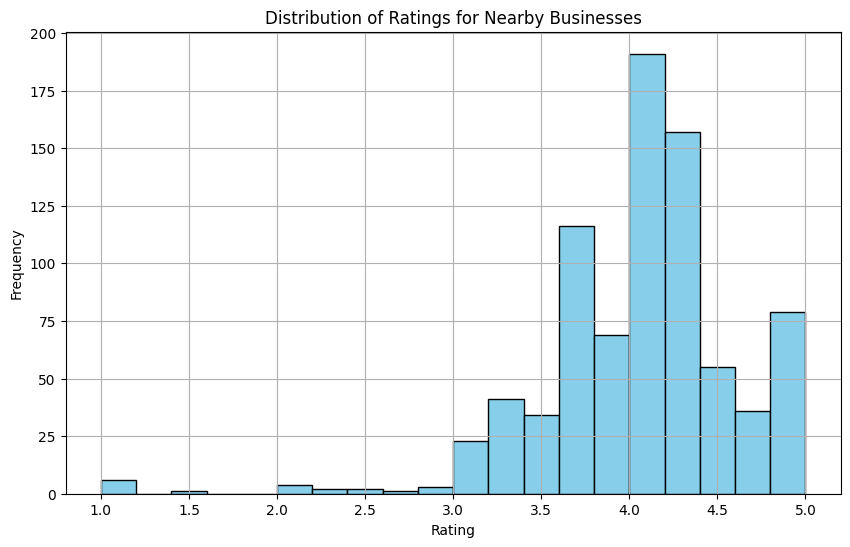

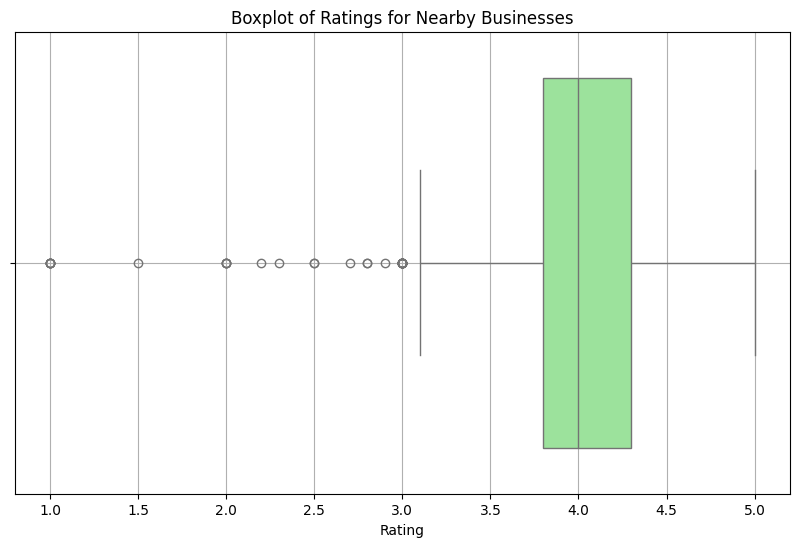

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of ratings
plt.figure(figsize=(10, 6))
plt.hist(df_nearby_businesses['Rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Ratings for Nearby Businesses')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Boxplot of ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_nearby_businesses['Rating'], color='lightgreen')
plt.title('Boxplot of Ratings for Nearby Businesses')
plt.xlabel('Rating')
plt.grid(True)
plt.show()

In [33]:
# Define high-rated businesses
high_rated_threshold = 4.0
high_rated_businesses = df_nearby_businesses[df_nearby_businesses['Rating'] >= high_rated_threshold]

# Calculate the proportion of high-rated businesses
proportion_high_rated = len(high_rated_businesses) / len(df_nearby_businesses)

print(f"Proportion of High-Rated Businesses (Rating >= {high_rated_threshold}): {proportion_high_rated:.2%}")

Proportion of High-Rated Businesses (Rating >= 4.0): 48.46%


In [34]:
# Extract the top 10 amenity types
top_amenities = amenity_avg_distance.head(10).index

# Filter df_nearby_poi to include only the top 10 amenity types
top_amenities_df = df_nearby_poi[df_nearby_poi['amenity'].isin(top_amenities)]

In [35]:
from shapely.geometry import Point
import geopandas as gpd

# Reproject to UTM Zone 31N (EPSG:32631)
chicken_rep_lagos_branch = chicken_rep_lagos_branch.to_crs(epsg=32631)
top_amenities_df = top_amenities_df.to_crs(epsg=32631)

# Function to calculate the nearest distance from a branch to an amenity type
def calculate_nearest_distance(branch_geometry, amenity_df):
    # Compute distances to all instances of the amenity type
    distances = amenity_df.geometry.distance(branch_geometry)
    # Return the minimum distance
    return distances.min()

# Create a dictionary to store results
nearest_distances_by_amenity = {}

# Calculate the nearest distance for each amenity type
for amenity in top_amenities:
    filtered_amenity_df = top_amenities_df[top_amenities_df['amenity'] == amenity]
    chicken_rep_lagos_branch[f'nearest_{amenity}_distance'] = chicken_rep_lagos_branch.geometry.apply(
        lambda x: calculate_nearest_distance(x, filtered_amenity_df)
    )
    # Store the average distance for this amenity type
    nearest_distances_by_amenity[amenity] = chicken_rep_lagos_branch[f'nearest_{amenity}_distance'].mean()

# Convert the results into a DataFrame for better visualization
nearest_distances_df = pd.DataFrame.from_dict(nearest_distances_by_amenity, orient='index', columns=['Average Distance (meters)'])
nearest_distances_df.sort_values(by='Average Distance (meters)', inplace=True)

# Print the results
print("Average Distance from Chicken Republic Branches to Top 10 Amenities:")
print(nearest_distances_df)

Average Distance from Chicken Republic Branches to Top 10 Amenities:
                  Average Distance (meters)
bank                            1229.450448
hospital                        1518.257972
marketplace                     2820.028876
clinic                          3770.728691
atm                             4348.554149
fuel                            6328.908435
post_office                     8728.715869
police                         12975.057517
community_centre               15607.975386
cafe                           16615.486339


In [36]:
import folium

# Ensure CRS is set correctly
chicken_rep_lagos_branch = chicken_rep_lagos_branch.to_crs(epsg=4326)
top_amenities_df = top_amenities_df.to_crs(epsg=4326)

# Initialize the map
m = folium.Map(
    location=[chicken_rep_lagos_branch['Latitude'].mean(), chicken_rep_lagos_branch['Longitude'].mean()],
    zoom_start=12,
    tiles="OpenStreetMap"
)

# Add Chicken Republic branches to the map
for _, row in chicken_rep_lagos_branch.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=7,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.8,
        tooltip=f"Chicken Republic Branch: {row['Location']}"
    ).add_to(m)

# Define a color mapping for unique amenities
amenity_colors = {
    'bank': 'gold',                # Banks are gold
    'hospital': 'red',             # Hospitals are red
    'marketplace': 'orange',       # Marketplaces are orange
    'clinic': 'lightcoral',        # Clinics are light coral
    'atm': 'darkgoldenrod',        # ATMs are dark goldenrod
    'fuel': 'black',               # Fuel stations are black
    'post_office': 'navy',         # Post offices are navy blue
    'police': 'blue',              # Police stations are blue
    'community_centre': 'green',   # Community centers are green
    'cafe': 'brown'                # Cafes are brown
}

# Default color if an amenity type is not in the mapping
default_color = 'gray'

# Add top amenities to the map
for _, row in top_amenities_df.iterrows():
    # Compute the centroid of the polygon and extract its coordinates
    if row.geometry.geom_type == 'Polygon':
        location = [row.geometry.centroid.y, row.geometry.centroid.x]
    else:
        location = [row.geometry.y, row.geometry.x]
    
    # Get the color for the amenity type
    amenity_type = row['amenity']
    color = amenity_colors.get(amenity_type, default_color)
    
    folium.CircleMarker(
        location=location,
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.8,
        tooltip=f"Amenity: {row['amenity']} ({row['name']})"
    ).add_to(m)

# Add a title to the map
title_html = '''
<div style="position: fixed; top: 10px; left: 50%; transform: translateX(-50%); z-index: 9999; 
            font-size: 20px; font-weight: bold; color: black; background-color: white; padding: 10px;">
    Spatial Distribution of Chicken Republic Branches and Nearby Amenities in Lagos
</div>
'''
m.get_root().html.add_child(folium.Element(title_html))

# Add a legend to the map
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; width: 200px; height: auto; 
            background-color: white; border: 2px solid black; z-index: 9999; padding: 10px;">
    <div><span style="color: blue; font-size: 20px;">•</span> Chicken Republic Branches</div>
'''

# Dynamically generate legend entries for each amenity type
for amenity, color in amenity_colors.items():
    legend_html += f'<div><span style="color: {color}; font-size: 20px;">•</span> {amenity.capitalize()}</div>'

legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map locally as an HTML file
m.save("Spatial Distribution of Chicken Republic Branches and Nearby Amenities in Lagos.html")

# Display the map
m